In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import wfdb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import neurokit2 as nk
from scipy.signal import resample, medfilt
import pywt
import pickle
import time
import os
import mne
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from zoneinfo import ZoneInfo

In [2]:
def preprocessing_data(data):
    coeffs = pywt.wavedec(data, 'db4', level=5) #Wavelet decomposition, reduces noise, enhances key elements
    data = pywt.waverec(coeffs, 'db4')
    data = medfilt(data, kernel_size=5) #Reduces noise further
    data = downsample(data, original_rate=360, target_rate=100) #Downsample form 360Hz to 100Hz, then feed sequences of 500Hz
    return data

In [3]:
def load_record(record_id, seq_len=1000, stride=1000):
    record_name = str(record_id)
    if not os.path.exists(f"mit_bih/{record_name}.dat"):
        wfdb.dl_database('mitdb', './', records=[record_name])
    record = wfdb.rdrecord('mit_bih/' + record_name)
    
    #Extract each channel
    signal_data = record.p_signal
    ch1 = preprocessing_data(signal_data[:, 0]).reshape(-1, 1)
    ch2 = preprocessing_data(signal_data[:, 1]).reshape(-1, 1)

    #Scale the signal
    scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
    ch1_scale = scaler.fit_transform(ch1)
    ch2_scale = scaler.fit_transform(ch2)
    
    # Create sequences using sliding window
    seq_ch1 = [ch1_scale[i:i+seq_len] for i in range(0, len(ch1_scale)-seq_len+1, stride)]
    seq_ch2 = [ch2_scale[i:i+seq_len] for i in range(0, len(ch2_scale)-seq_len+1, stride)]
    seq_ch1.extend(seq_ch2)
    return seq_ch1

def load_multiple_records(record_ranges, seq_len=1000, stride_len=100):
    all_data = []
    for start, end in tqdm(record_ranges):
        for record_id in range(start, end + 1):
            record_data = load_record(record_id, seq_len, stride_len)
            all_data.extend(record_data)
    # Save to pkl
    with open('database.pkl', 'wb') as f:
        pickle.dump(all_data, f)
    
    return all_data

In [4]:
def downsample(data, original_rate, target_rate):
    num_samples = int(len(data) * target_rate / original_rate)
    return resample(data, num_samples)

def calculate_l1(predictions, targets):
    l1_norm = torch.norm(predictions-targets, p=1)
    l1_sum = torch.sum(torch.abs(targets))
    accuracy = 100 * (1 - (l1_norm / l1_sum))
    return accuracy

def calculate_l2(predictions, targets):
    l2_norm = torch.norm(predictions - targets, p=2)
    l2_sum = torch.norm(targets, p=2)
    accuracy = 100 * (1 - (l2_norm / l2_sum))
    return accuracy

def calculate_MAPE(predictions, targets):
    mape = torch.mean(torch.abs((targets - predictions) / (targets)))
    return mape

In [5]:
def fixed_position_mask_peaks(rpeaks, seq, mask_length, num_peaks_to_mask):
    mask = np.zeros_like(seq, dtype=bool)  # Create a mask with the same length as seq, initially all False

    if len(rpeaks) > 0:  # If there are detected peaks
        # Randomly select 'num_peaks_to_mask' peaks from rpeaks
        selected_peaks = rpeaks[1:2*num_peaks_to_mask + 1: 2]

        for peak in selected_peaks:
            mask_half = mask_length // 2
            start = int(max(0, peak - mask_half))
            end = int(min(len(seq), peak + mask_half))
            mask[start:end] = True
    
    return mask

In [6]:
class ECGDataset(Dataset):
    def __init__(self, data, seq_len=1000, mask_length=60, target_rate=100,num_peaks_to_mask=1):
        """
        Args:
            data (np.array): Full ECG signal data.
            seq_len (int): Length of each sequence before downsampling.
            mask_length (int): Length of masking window around the first R-peak.
            original_rate (int): Original sampling rate of the data (default: 360 Hz).
            target_rate (int): Target sampling rate after downsampling (default: 100 Hz).
        """
        self.data = data
        self.seq_len = seq_len
        self.mask_length = mask_length
        self.target_rate = target_rate
        self.num_peaks_to_mask = num_peaks_to_mask
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Adjust index for downsampled sequences
        seq = self.data[idx].flatten()
        # Detect R-peaks in the sequence
        rpeaks = nk.ecg_findpeaks(seq, sampling_rate=self.target_rate)['ECG_R_Peaks']

        # Create masking array
        mask = np.zeros_like(seq, dtype=bool)
        mask = fixed_position_mask_peaks(rpeaks, seq, self.mask_length, self.num_peaks_to_mask)
        
        masked_seq = seq.copy()
        masked_seq[mask] = 0  # Apply masking

        mask = torch.tensor(mask, dtype=torch.bool)
        return torch.tensor(masked_seq, dtype=torch.float32), torch.tensor(seq, dtype=torch.float32), mask

In [7]:
# Masked Autoencoder
class MAE1D(nn.Module):
    def __init__(self, embed_dim=32, hidden_dim=64, lstm_hidden_dim=128):
        super(MAE1D, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, embed_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(embed_dim, embed_dim * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(embed_dim * 2, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # BiLSTM layer, processes sequence forwards and backwars
        self.bilstm = nn.LSTM(hidden_dim, lstm_hidden_dim, bidirectional=True, batch_first=True)

        self.decoder = nn.Sequential(
            nn.Conv1d(lstm_hidden_dim * 2, embed_dim * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True),

            nn.Conv1d(embed_dim * 2, embed_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True),

            nn.Conv1d(embed_dim, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x, mask):
        # print(f"Input shape: {x.shape}")
        x = x.unsqueeze(1)
        # print(f"Shape after unsqueeze (adding channel): {x.shape}")
        encoded = self.encoder(x)
        # print(f"Shape after encoding: {encoded.shape}")
        encoded = encoded.permute(0, 2, 1)
        lstm_out, _ = self.bilstm(encoded)
        
        lstm_out = lstm_out.permute(0, 2, 1)
        decoded = self.decoder(lstm_out)

        x_reconstructed = decoded.squeeze(1)
        # print(f"Shape after squeeze: {x_reconstructed.shape}")

        return x_reconstructed

In [8]:
# Data preparation
def prepare_data(data, seq_len, num_rpeaks,batch_size=128):
    dataset = ECGDataset(data, seq_len, num_peaks_to_mask = num_rpeaks)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [9]:
class Trainer:
    def __init__(self, model, criterion, optimizer, seq_len=5000, num_rpeak=1, log_dir=None, test_case = True):
        self.seq_len = seq_len
        self.num_rpeak = num_rpeak
        self.device = ( "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        self.model = model.to(self.device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.log_dir = log_dir
        self.test_case = test_case
        self.cur_time = datetime.now(ZoneInfo("Australia/Sydney")).strftime("%H%M_%d%m%Y")
        if self.log_dir is None:
            self.log_dir = f'runs/seq{seq_len}_rpeak{num_rpeak}_{self.cur_time}'
        if self.test_case == False:
            self.writer = SummaryWriter(log_dir=self.log_dir)

    def run(self, train_loader, val_loader, test_loader, epochs=100, patience = 10):
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            for masked_seq, original_seq, mask in train_loader:
                masked_seq, original_seq, mask = masked_seq.to(self.device), original_seq.to(self.device), mask.to(self.device)

                self.optimizer.zero_grad()
                reconstructed = self.model(masked_seq, mask)

                loss_global = self.criterion(reconstructed, original_seq)
                loss_masked = self.criterion(reconstructed[mask], original_seq[mask])
                loss = 0.9 * loss_masked + 0.1 * loss_global

                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            self.train_losses.append(avg_train_loss)

            avg_val_loss, avg_l1, avg_l2, avg_MAPE = self.evaluate(epoch=epoch, data_loader = val_loader)
            self.val_losses.append(avg_val_loss)

            print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
                  f"L1 Accuracy: {avg_l1:.2f}, L2 Accuracy: {avg_l2:.2f}, MAPE Accuracy: {avg_MAPE:.2f}")
            if self.test_case == False:
                self.writer.add_scalar("Loss/Train", avg_train_loss, epoch)
                self.writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
                self.writer.add_scalar("Accuracy/L1", avg_l1, epoch)
                self.writer.add_scalar("Accuracy/L2", avg_l2, epoch)
                self.writer.add_scalar("Accuracy/MAPE", avg_MAPE, epoch)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                print(f"{self.log_dir}/model_{self.seq_len}_{self.num_rpeak}_{self.cur_time}.pth")
                if self.test_case == False:
                    print("Saving the best model checkpoint...")
                    torch.save(self.model.state_dict(), f"{self.log_dir}/model_{self.seq_len}_{self.num_rpeak}_{self.cur_time}.pth")
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

        self.writer.close()
        if test_loader is None:
            self.final_evaluation(val_loader)
        else: 
            self.final_evaluation(test_loader)
            
    def evaluate(self, data_loader, epoch= None):
        self.model.eval()
        val_loss = 0.0
        l1_accuracy = 0.0
        l2_accuracy = 0.0
        MAPE_accuracy = 0.0

        with torch.no_grad():
            for masked_seq, original_seq, mask in data_loader:
                masked_seq, original_seq, mask = masked_seq.to(self.device), original_seq.to(self.device), mask.to(self.device)
                reconstructed = self.model(masked_seq, mask)
                masked_reconstructed = reconstructed[mask]
                masked_original = original_seq[mask]
                loss = self.criterion(masked_reconstructed, masked_original)
                val_loss += loss.item()
                l1_accuracy += calculate_l1(masked_reconstructed, masked_original)
                l2_accuracy += calculate_l2(masked_reconstructed, masked_original)
                MAPE_accuracy += calculate_MAPE(masked_reconstructed, masked_original)

        avg_val_loss = val_loss / len(data_loader)
        avg_l1 = l1_accuracy / len(data_loader)
        avg_l2 = l2_accuracy / len(data_loader)
        avg_MAPE = MAPE_accuracy / len(data_loader)

        if epoch is None:
            print(f"\nValidation Loss: {avg_val_loss:.4f}")
            print(f"L1 Accuracy: {avg_l1:.4f}")
            print(f"L2 Accuracy: {avg_l2:.4f}")
            print(f"MAPE Accuracy: {avg_MAPE:.2f}%")

        return avg_val_loss, avg_l1, avg_l2, avg_MAPE
    def plot_predictions_with_residuals(self, model, data_loader, sample_len = None, num_samples=2 ):
        self.model.eval()
        all_actual, all_predicted, all_masks = [], [], []
        if sample_len is None:
            sample_len = self.seq_len
        
        with torch.no_grad():
            for masked_seq, original_seq, mask in data_loader:
                masked_seq, original_seq = masked_seq.to(self.device), original_seq.to(self.device)
                reconstructed = model(masked_seq, mask)
                all_actual.extend(original_seq.cpu().numpy())  # original (unmasked) ECG
                all_predicted.extend(reconstructed.cpu().numpy())  # predictions
                all_masks.extend(mask.cpu().numpy()) # Masked regions
     
                break  # Take only one batch for plotting
        
        # Flatten the lists for metric calculation
        all_actual_flat = np.concatenate(all_actual)
        all_predicted_flat = np.concatenate(all_predicted)
        
        # Calculate metrics
        mse = mean_squared_error(all_actual_flat, all_predicted_flat)
        mae = mean_absolute_error(all_actual_flat, all_predicted_flat)
        r2 = r2_score(all_actual_flat, all_predicted_flat)
    
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R-squared (R²): {r2:.4f}")
        
        # Visualize predictions vs. actual data with residuals
        plt.figure(figsize=(15, num_samples * 5))
        for i in range(min(num_samples, len(all_actual))):
            original = all_actual[i]
            predicted = all_predicted[i]
            mask = all_masks[i]
    
            # Plot predictions vs actual data
            plt.subplot(num_samples, 2, i * 2 + 1)
            plt.plot(original[:sample_len], label="Original", color="blue", alpha=0.7)
            plt.plot(predicted[:sample_len], label="Predicted", color="orange", alpha=0.7)
    
            # Highlight masked regions
            masked_indices = np.where(mask)[0]
            plt.scatter(masked_indices, original[masked_indices], color="red", label="Masked Regions", alpha=0.7)
    
            plt.title(f"Sample {i + 1} - Predictions")
            plt.legend()
    
            # Compute and plot residuals
            residuals = np.array(original) - np.array(predicted)
            plt.subplot(num_samples, 2, i * 2 + 2)
            plt.plot(residuals[:sample_len], label="Residuals", color="green")
            plt.axhline(0, color="black", linestyle="--")
            plt.title(f"Sample {i + 1} - Residuals")
            plt.legend()
    
        plt.tight_layout()
        plt.show()

    def plot_loss_curves(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label="Train Loss", marker='o')
        plt.plot(self.val_losses, label="Validation Loss", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Curves")
        plt.legend()
        plt.grid()
        plt.show()
        
    def final_evaluation(self, data_loader):
        self.evaluate(data_loader, epoch= None)
        self.plot_predictions_with_residuals(self.model, data_loader, sample_len = 1000)
        self.plot_loss_curves()

In [10]:
def plot_some_sample(data_loader, device, num_samples=5):
    all_actual, all_masks = [], []
    with torch.no_grad():
        for masked_seq, original_seq, mask in data_loader:
            all_actual.extend(original_seq)  # original (unmasked) ECG
            all_masks.extend(mask) # Masked regions
            break
            
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(min(num_samples, len(all_actual))):
        original = all_actual[i]
        mask = all_masks[i]

        # Plot predictions vs actual data
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.plot(original, label="Original", color="blue", alpha=0.7)

        # Highlight masked regions
        masked_indices = np.where(mask)[0]
        plt.scatter(masked_indices, original[masked_indices], color="red", label="Masked Regions", alpha=0.7)

        plt.title(f"Sample {i + 1} - Predictions")
        plt.legend()    

def plot_ecg_sample_no_mask(data, num_samples=2):
    # Visualize predictions vs. actual data with residuals
    fig, ax = plt.subplots(1, num_samples, figsize = (16,9))
    ax = ax.flatten()
    for i in range(0, num_samples):
        # Plot predictions vs actual data
        ax[i].plot(data[i], label="Original", color="blue", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
record_ranges = [(100,109),(111, 119),(121,124),(200,203),(205,205),(207,210),(212,215),(217,217),(219,223),(228,228),(230,232)]
print("Working with data")
seq_len = 5000
stride = 500
data = np.array(load_multiple_records(record_ranges, seq_len, stride))
test_data = load_multiple_records([(233,234)], seq_len, stride)

for num in [6, 8, 10]:
    print("="*20)
    print(f"Training the model with {num} R peaks")
    print("="*20)
    
    print("Preparing the data")
    train_loader, val_loader = prepare_data(data,num_rpeaks = num, seq_len=seq_len)
    test_dataset = ECGDataset(test_data, seq_len, num_peaks_to_mask = num)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    print("Training the model")
    criterion = nn.MSELoss()
    mae_model = MAE1D()
    optimizer = optim.Adam(mae_model.parameters(), lr=0.001)    

    model_trainer = Trainer(model = mae_model, criterion = criterion, optimizer = optimizer,  seq_len=seq_len, num_rpeak=num, test_case = False)
    model_trainer.run(train_loader, val_loader, test_loader, epochs = 60)

Working with data


  9%|████████                                                                                | 1/11 [00:01<00:13,  1.34s/it]


Validation Loss: 0.0018
L1 Accuracy: 66.8643
L2 Accuracy: 58.6670
MAPE Accuracy: 1.61%
Mean Squared Error (MSE): 0.0006
Mean Absolute Error (MAE): 0.0143
R-squared (R²): 0.9317


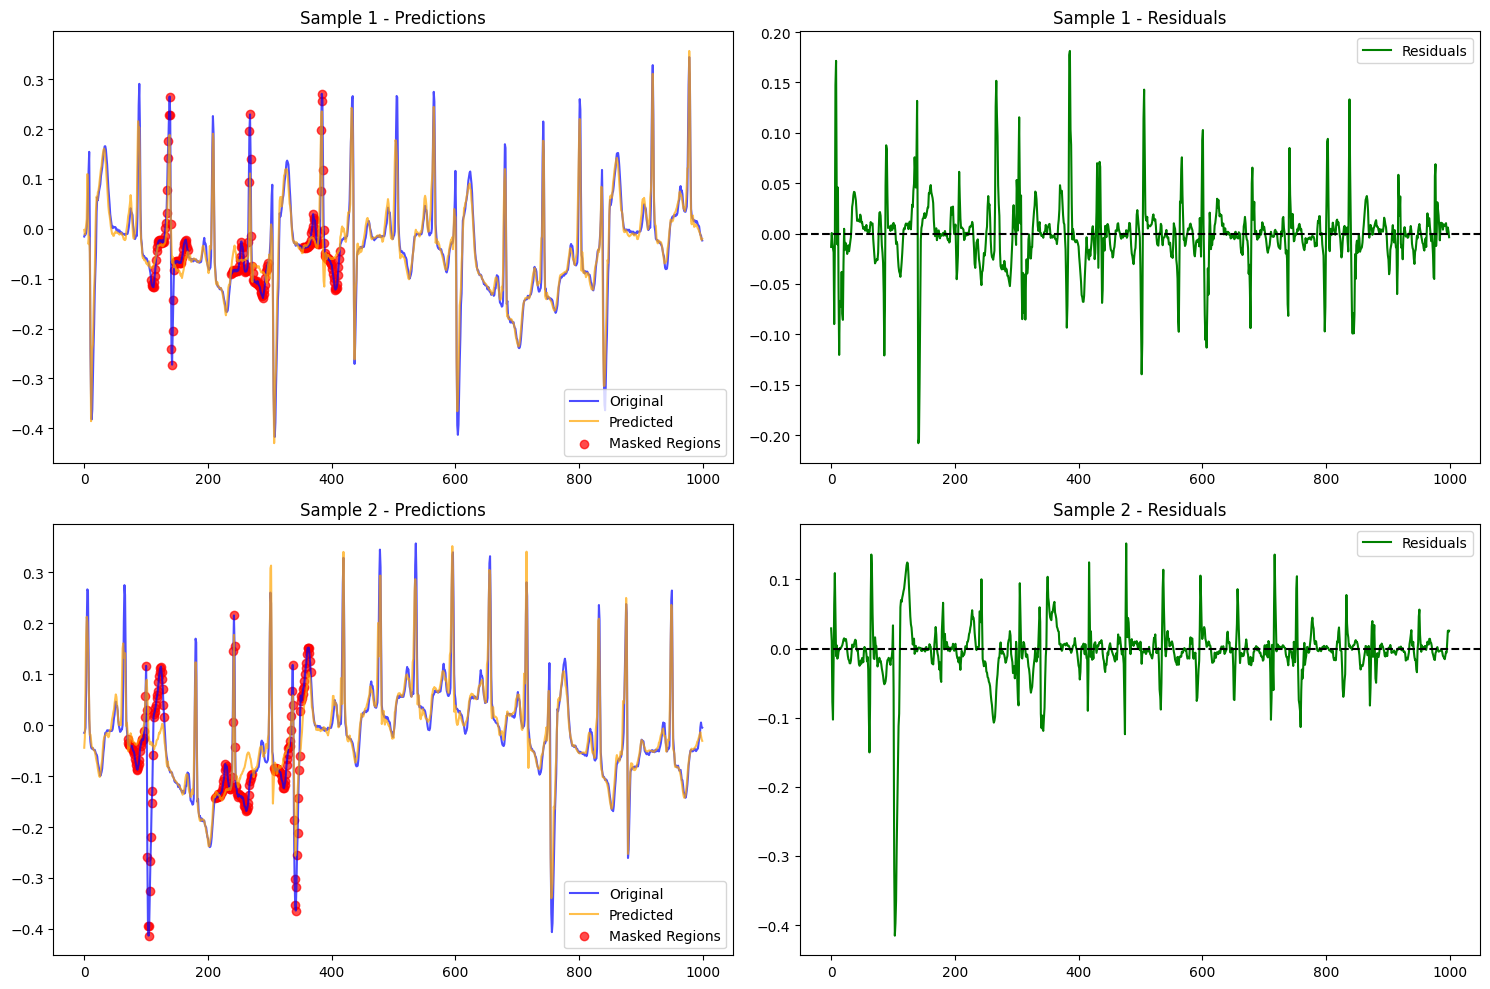

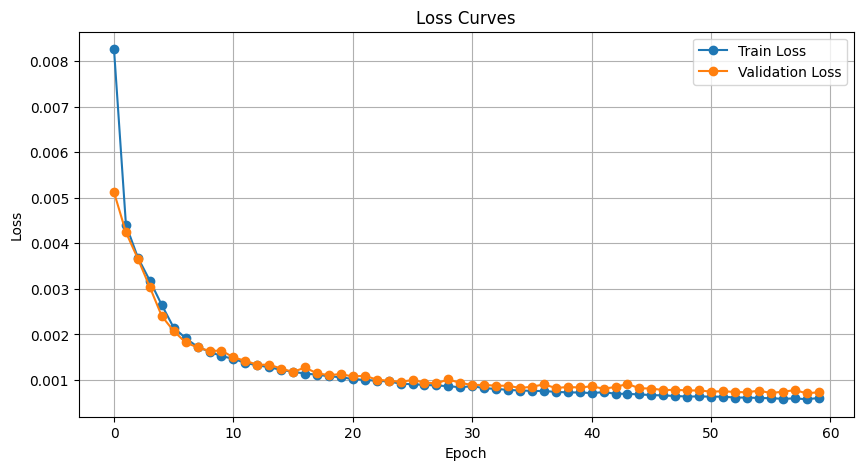

In [17]:
model_trainer.final_evaluation(test_loader)

Working with data


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


Preparing the data

Validation Loss: 0.0036
L1 Accuracy: 51.1893
L2 Accuracy: 42.8149
MAPE Accuracy: 2.63%
Mean Squared Error (MSE): 0.0008
Mean Absolute Error (MAE): 0.0168
R-squared (R²): 0.9036


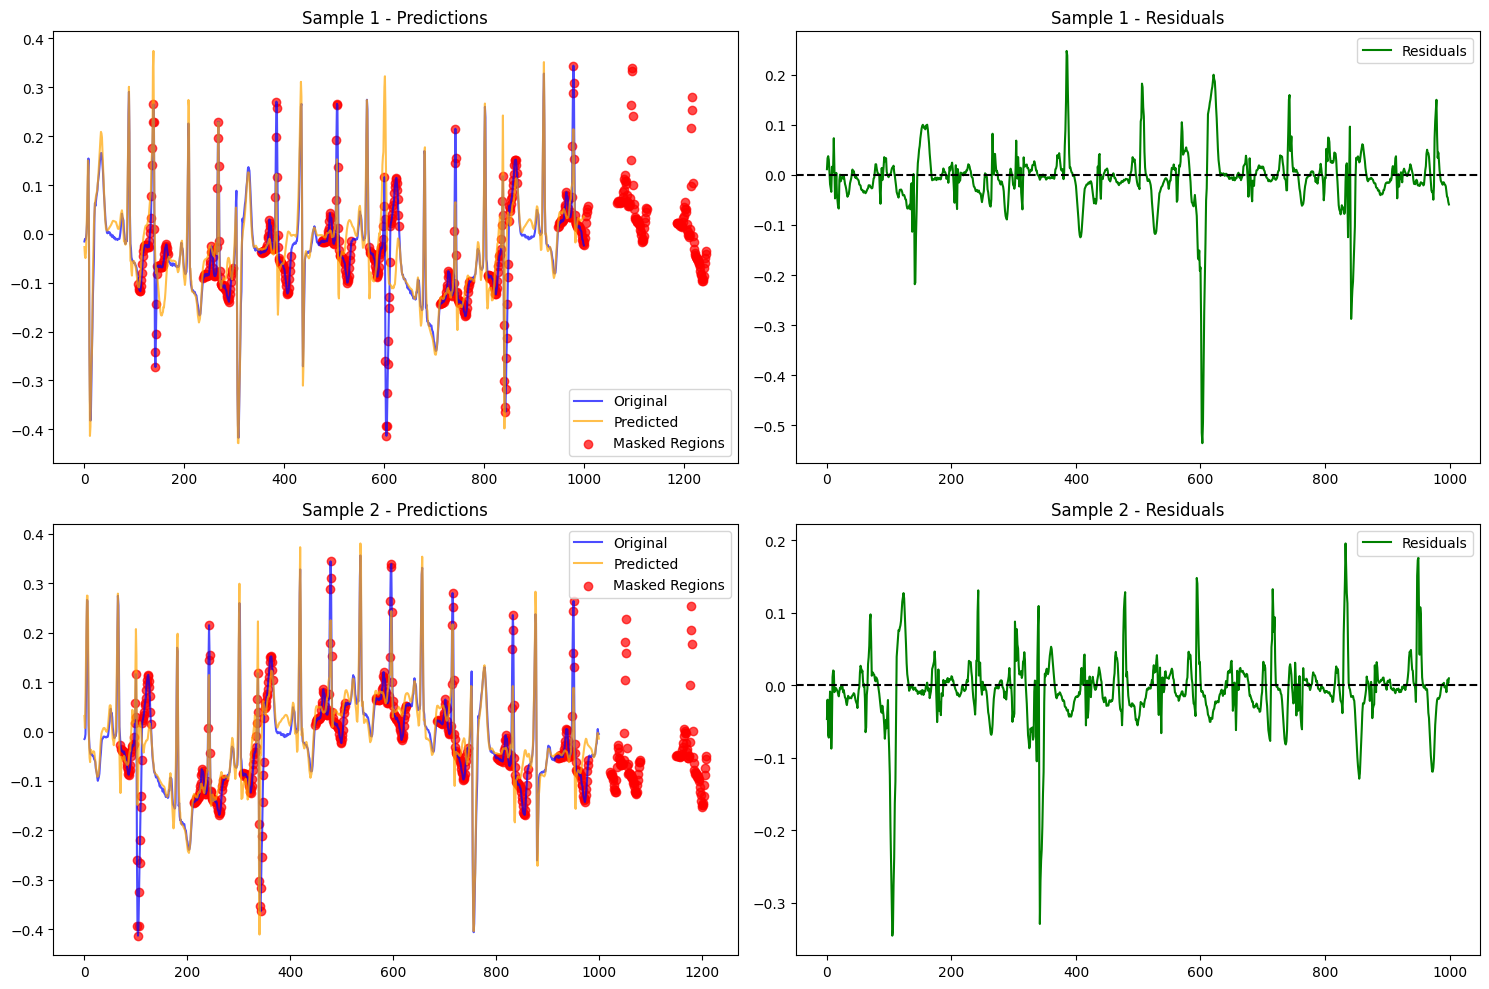

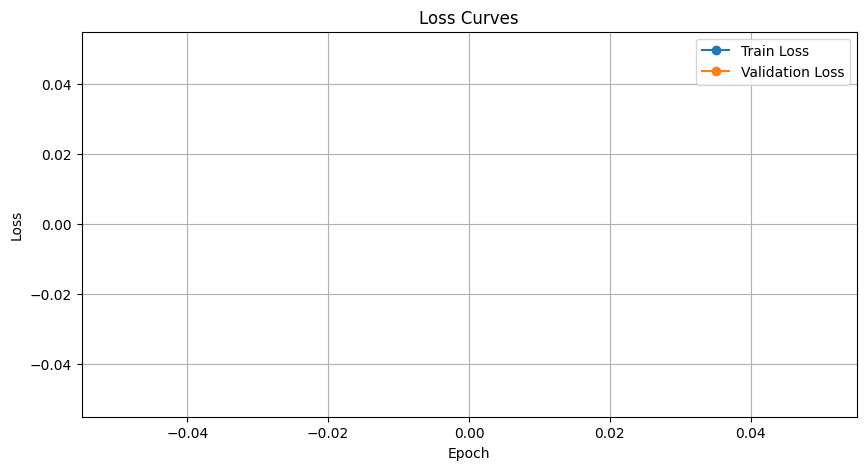

In [13]:
record_ranges = [(100,109),(111, 119),(121,124),(200,203),(205,205),(207,210),(212,215),(217,217),(219,223),(228,228),(230,232)]
print("Working with data")
seq_len = 5000
stride = 500
data = np.array(load_multiple_records(record_ranges, seq_len, stride))
test_data = load_multiple_records([(233,234)], seq_len, stride)

print("Preparing the data")
train_loader, val_loader = prepare_data(data,num_rpeaks = 10, seq_len=seq_len)
test_dataset = ECGDataset(test_data, seq_len, num_peaks_to_mask = 10)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


mae_model.load_state_dict(torch.load('best_model.pth', weights_only=True))
criterion = nn.MSELoss()
optimizer = optim.Adam(mae_model.parameters(), lr=0.001)    
model_trainer = Trainer(model = mae_model, criterion = criterion, optimizer = optimizer,  seq_len=5000, num_rpeak=2, test_case = True)
model_trainer.final_evaluation(test_loader)

# Fine- truning

In [14]:
from torch.utils.data import DataLoader, TensorDataset

def load_wesad_dataset(root_dir, test_subject):
    folder_ls = os.listdir(root_dir)
    for i in folder_ls:
        if i == ".ipynb_checkpoints" or i == '.DS_Store':
            print(f"Removing {i}")
            folder_ls.remove(i)
    
    valid_ls = ['S2']
    train_ls = [subject for subject in folder_ls if subject not in valid_ls]

    # Create the train list by excluding test_ls
    train_ls = [subject for subject in folder_ls if subject not in valid_ls]
    print("==========Loading Training set============")
    X_train, y_train = load_process_extract_ls(root_dir, train_ls,700, 5,5,True)
    print("==========Loading Testing set============")
    X_test, y_test = load_process_extract_ls(root_dir,valid_ls,700, 5, 5,False)
    return X_train, X_test, y_train, y_test
    
class ECGClassificationDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X  # shape: [N, L]
        self.Y = Y  # shape: [N]
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        seq = self.X[idx].flatten()
        return torch.tensor(seq, dtype=torch.float32).unsqueeze(0), torch.tensor(self.Y[idx], dtype=torch.long)

In [15]:
from wesad_processing import *
X_train, X_test, y_train, y_test = load_wesad_dataset('/home/van/NamQuang/ECG_Research/WESAD_LOSO', 'S2.pkl')
train_dataloader = ECGClassificationDataset(X_train, y_train)
test_dataloader = ECGClassificationDataset(X_test, y_test)

Removing .DS_Store
==========Loading Training set============
minmax
5-15
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S16/S16.pkl
minmax
5-15
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S9/S9.pkl
minmax
5-15
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S13/S13.pkl
minmax
5-15
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S8/S8.pkl
minmax
5-15
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S4/S4.pkl
minmax
5-15
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S11/S11.pkl
minmax
5-15
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S15/S15.pkl
minmax
5-15
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S3/S3.pkl
minmax
5-15
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S6/S6.pkl
minmax
5-15
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S7/S7.pkl
minmax
5-15
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S14/S14.pkl
minmax
5-15
Working with: /home/van/NamQuang/ECG_Research/W

In [16]:
train_size = int(0.8 * len(train_dataloader))
val_size = len(train_dataloader) - train_size
train_dataset, val_dataset = random_split(train_dataloader, [train_size, val_size])

train_loader_wesad = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader_wesad = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader_wesad = DataLoader(test_dataloader, batch_size=128, shuffle=False)

In [17]:
import torch.nn.functional as F


class DownstreamClassifier(nn.Module):
    def __init__(self, encoder, hidden_dim = 64, num_classes=2):
        super(DownstreamClassifier, self).__init__()
        self.encoder = encoder
        # Freeze encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Classifier head after GAP
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),  # hidden_dim = last conv channels output
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            z = self.encoder(x)  # shape: (B, C=hidden_dim, L)
        
        # Global Average Pooling over the sequence dimension (L)
        z = F.adaptive_avg_pool1d(z, 1)  # shape: (B, C, 1)
        z = z.squeeze(-1)                 # shape: (B, C)
        logits = self.classifier(z)
        return logits

In [18]:
# Load model and pretrained weights
auto_model = MAE1D(seq_len = 1000)
auto_model.load_state_dict(torch.load('best_model_3_1_rpeaks.pth', weights_only=True))
frozen_encoder = auto_model.encoder
model = DownstreamClassifier(frozen_encoder)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

# Train loop
model.train()
num_epochs = 100

val_losses = []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    total_loss = 0
    all_train_preds = []
    all_train_labels = []

    for x, y in train_loader_wesad:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(y.cpu().numpy())

    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_f1_macro = f1_score(all_train_labels, all_train_preds, average='macro')

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for x_val, y_val in val_loader_wesad:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(y_val.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader_wesad)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_f1_macro = f1_score(all_val_labels, all_val_preds, average='macro')
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch}: "
          f"Train Loss = {total_loss/len(train_loader_wesad):.4f}, "
          f"Train Acc = {train_accuracy:.4f}, "
          f"Train F1 = {train_f1_macro:.4f} | "
          f"Val Loss = {avg_val_loss:.4f}, "
          f"Val Acc = {val_accuracy:.4f}, "
          f"Val F1 = {val_f1_macro:.4f}")

Epoch 0: Train Loss = 0.5526, Train Acc = 0.7773, Train F1 = 0.4521 | Val Loss = 0.5241, Val Acc = 0.7771, Val F1 = 0.4373
Epoch 1: Train Loss = 0.4779, Train Acc = 0.7919, Train F1 = 0.5017 | Val Loss = 0.4517, Val Acc = 0.8280, Val F1 = 0.6375
Epoch 2: Train Loss = 0.4182, Train Acc = 0.8370, Train F1 = 0.6694 | Val Loss = 0.4170, Val Acc = 0.8544, Val F1 = 0.7262
Epoch 3: Train Loss = 0.3969, Train Acc = 0.8461, Train F1 = 0.7063 | Val Loss = 0.4067, Val Acc = 0.8532, Val F1 = 0.7306
Epoch 4: Train Loss = 0.3864, Train Acc = 0.8496, Train F1 = 0.7146 | Val Loss = 0.3994, Val Acc = 0.8550, Val F1 = 0.7303
Epoch 5: Train Loss = 0.3788, Train Acc = 0.8515, Train F1 = 0.7227 | Val Loss = 0.3888, Val Acc = 0.8544, Val F1 = 0.7359
Epoch 6: Train Loss = 0.3736, Train Acc = 0.8514, Train F1 = 0.7231 | Val Loss = 0.3845, Val Acc = 0.8532, Val F1 = 0.7368
Epoch 7: Train Loss = 0.3681, Train Acc = 0.8529, Train F1 = 0.7337 | Val Loss = 0.3779, Val Acc = 0.8550, Val F1 = 0.7358
Epoch 8: Train L

In [19]:
from sklearn.metrics import f1_score
import torch
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
def evaluate_f1_macro(model, dataloader, criterion, device):
    # --- Validation ---
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for x_val, y_val in dataloader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(y_val.cpu().numpy())

    avg_val_loss = val_loss / len(dataloader)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_f1_macro = f1_score(all_val_labels, all_val_preds, average='macro')
    val_losses.append(avg_val_loss)
    
    return avg_val_loss, val_f1_macro

val_loss, val_f1 = evaluate_f1_macro(model, test_loader_wesad, criterion, device)
print(f"Validation Loss: {val_loss:.4f}, Macro F1 Score: {val_f1:.4f}")

Validation Loss: 1.8870, Macro F1 Score: 0.4404
